In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
from datasets import load_dataset
dataset = load_dataset("financial_phrasebank", "sentences_50agree")

df = dataset['train'].to_pandas()

c:\Users\fabian\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Axes: >

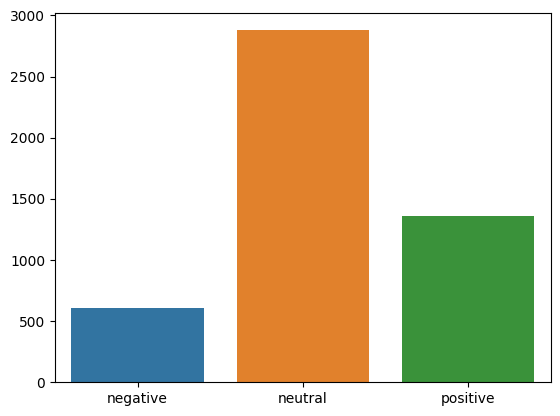

In [4]:
count = df['label'].value_counts()
bar_data = pd.DataFrame({'negative': [count[0]], 'neutral': [count[1]]
        , 'positive': [count[2]]})
sns.barplot(data=bar_data)

# Preprocessing

In [5]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

In [6]:
# Lemmatize
lemma = WordNetLemmatizer()
stopwords = stopwords.words('english')

def clean_text(text: str) -> list:
    corpus = str(text).lower()
    corpus = re.sub('[^a-zA-Z]+',' ', corpus).strip()
    tokens = word_tokenize(corpus)
    words = [i for i in tokens if i not in stopwords]
    lemmatize = [lemma.lemmatize(w) for w in words]

    return lemmatize

preprocess_text = [clean_text(i) for i in df['sentence']]
df['preprocess_text'] = preprocess_text

# Method 1 Positive and Negative Word Count with Normalization

In [7]:
# Importing list of positive and negative words
with open('positive-words.txt', 'r') as file1:
    pos_words = file1.read()

with open('negative-words.txt', 'r') as file2:
    neg_words = file2.read()

pos_words = [i for i in pos_words.split('\n')]
neg_words = [i for i in neg_words.split('\n')]

count_pos = df['preprocess_text'].map(lambda x: len([i for i in x if i in pos_words]))
count_neg = df['preprocess_text'].map(lambda x: len([i for i in x if i in neg_words]))

df['count_pos'] = count_pos
df['count_neg'] = count_neg

df['total_len'] = df['preprocess_text'].map(lambda x: len(x))

df['sentiment_score'] = round((df['count_pos'] - df['count_neg']) /df['total_len'], 2)


In [8]:
'''
Let's test the accuracy of the sentiment score
We set an arbitrary classification rule of the following:

sentiment_score < -threshold     ---> Negative
-threshold<=sentiment_score<=threshold ---> Neutral
sentiment_score > threshold     ---> Positive

with the threshold being a value we can set.
'''

def score_classification(score, threshold):
    if score < -threshold:
        res = 0
    elif score <= threshold:
        res = 1
    else:
        res = 2
    
    return res

thresholds = [0.01, 0.02, 0.05, 0.10, 0.2, 0.5, 0.75, 1] # list of threshold values we can test

for threshold in thresholds:
    df['sentiment_score {}'.format(threshold)] = df['sentiment_score'].map(lambda x: score_classification(x, threshold))
    result = df.apply(lambda x: 1 if x['sentiment_score {}'.format(threshold)] == x['label'] else 0, axis=1).sum()
    df.drop(['sentiment_score {}'.format(threshold)], axis=1)
    accuracy = result / len(df) * 100
    print("The overall accuracy with a threshold of {} is {:.2f}%".format(threshold, accuracy))


The overall accuracy with a threshold of 0.01 is 54.91%
The overall accuracy with a threshold of 0.02 is 54.91%
The overall accuracy with a threshold of 0.05 is 55.28%
The overall accuracy with a threshold of 0.1 is 57.94%
The overall accuracy with a threshold of 0.2 is 59.33%
The overall accuracy with a threshold of 0.5 is 59.29%
The overall accuracy with a threshold of 0.75 is 59.33%
The overall accuracy with a threshold of 1 is 59.39%


## Method 2 VADER SentimentIntensityAnalyser

In [9]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent = SentimentIntensityAnalyzer()

polarity = [round(sent.polarity_scores(t)['compound'], 2) for t in df['sentence']]
df['sentiment_score (VADER)'] = polarity

In [10]:
# Using the same rule of classification as before
for threshold in thresholds:
    df['sentiment_score (VADER) {}'.format(threshold)] = df['sentiment_score (VADER)'].map(lambda x: score_classification(x, threshold))
    result = df.apply(lambda x: 1 if x['sentiment_score (VADER) {}'.format(threshold)] == x['label'] else 0, axis=1).sum()
    df.drop(['sentiment_score {}'.format(threshold)], axis=1)
    accuracy = result / len(df) * 100
    print("The overall accuracy (VADER) with a threshold of {} is {:.2f}%".format(threshold, accuracy))


The overall accuracy (VADER) with a threshold of 0.01 is 54.27%
The overall accuracy (VADER) with a threshold of 0.02 is 54.25%
The overall accuracy (VADER) with a threshold of 0.05 is 54.44%
The overall accuracy (VADER) with a threshold of 0.1 is 54.97%
The overall accuracy (VADER) with a threshold of 0.2 is 55.43%
The overall accuracy (VADER) with a threshold of 0.5 is 61.33%
The overall accuracy (VADER) with a threshold of 0.75 is 59.68%
The overall accuracy (VADER) with a threshold of 1 is 59.41%


## Method 3 Using TF-IDF and Scikit-Learn classifiers

In [11]:
# We need to pre process text in a different way for this method
combine_words = lambda x: ' '.join(i for i in x)
df['preprocess_text'] = df['preprocess_text'].apply(combine_words)

In [12]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    df['preprocess_text'], df['label'], test_size=0.25, random_state=42)

print("Train: {}, Test: {}".format((X_train.shape, y_train.shape), (X_test.shape, y_test.shape)))
X_train

Train: ((3634,), (3634,)), Test: ((1212,), (1212,))


4229      resident access block planned aleksandri street
2598    company operates business two reportable segme...
4524    however increase signaling traffic waste netwo...
1161    ahlstrom corporation stock exchange release ah...
1873    winner included honda odyssey minivan nissan a...
                              ...                        
4426    currency effect pct mln euro mln negative impa...
466     lidskoe pivo investment program foresees integ...
3092    product include consumer electronics device mo...
3772              bridge part highway development project
860     adp news oct finnish consulting engineering co...
Name: preprocess_text, Length: 3634, dtype: object

In [13]:
# TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

# Metrics
from sklearn.metrics import classification_report

tf_x_train = vectorizer.fit_transform(X_train)
tf_x_test = vectorizer.transform(X_test)

In [14]:
# SVC
from sklearn.svm import LinearSVC
svm = LinearSVC(random_state=0)

svm.fit(tf_x_train, y_train)
y_test_pred = svm.predict(tf_x_test)

report = classification_report(y_test, y_test_pred, output_dict=True)
report['weighted avg']

c:\Users\fabian\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


{'precision': 0.729014288096451,
 'recall': 0.7351485148514851,
 'f1-score': 0.7268776668497455,
 'support': 1212.0}

In [15]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression(max_iter=1000, solver='saga')

lgr.fit(tf_x_train, y_train)
y_test_pred = lgr.predict(tf_x_test)

report = classification_report(y_test, y_test_pred, output_dict=True)
report['weighted avg']

{'precision': 0.7371480589917992,
 'recall': 0.7326732673267327,
 'f1-score': 0.7095368658592509,
 'support': 1212.0}

In [16]:
# SVM
from sklearn.svm import SVC

svm = SVC()
svm.fit(tf_x_train, y_train)
y_test_pred = svm.predict(tf_x_test)

report = classification_report(y_test, y_test_pred, output_dict=True)
report['weighted avg']

{'precision': 0.7352294650647331,
 'recall': 0.721947194719472,
 'f1-score': 0.6900290980608877,
 'support': 1212.0}

In [17]:
# Optimizing hyperparameters using GridSearchCV
from sklearn.model_selection import GridSearchCV


param_grid = {"C": [0.1, 1, 10, 100], "gamma": [1, 0.1, 0.01, 0.001]
              , "kernel": ['rbf', 'poly', 'sigmoid']}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, error_score='raise')
grid.fit(tf_x_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.4s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.9s
[CV] END .....................C=0.1, gamma=1, k

GridSearchCV(error_score='raise', estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=2)

In [18]:
grid_predictions = grid.predict(tf_x_test)

print("Best parameters are {}".format(grid.best_params_))
print("Best accuracy score {}".format(grid.best_score_))
print(classification_report(y_test, grid_predictions))

Best parameters are {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best accuracy score 0.7377520358013043
              precision    recall  f1-score   support

           0       0.69      0.57      0.62       143
           1       0.77      0.86      0.81       713
           2       0.68      0.58      0.62       356

    accuracy                           0.74      1212
   macro avg       0.72      0.67      0.69      1212
weighted avg       0.74      0.74      0.74      1212



## Method 4 Using Neural Networks

In [23]:
import transformers
from transformers import BertModel, BertTokenizer
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NameError: name '_C' is not defined

In [ ]:
# Model
MODEL_NAME = 'bert-base-cased'

# Tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\fabian\AppData\Local\Temp\ipykernel_13432\3043336594.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


Text(0.5, 0, 'Token count')

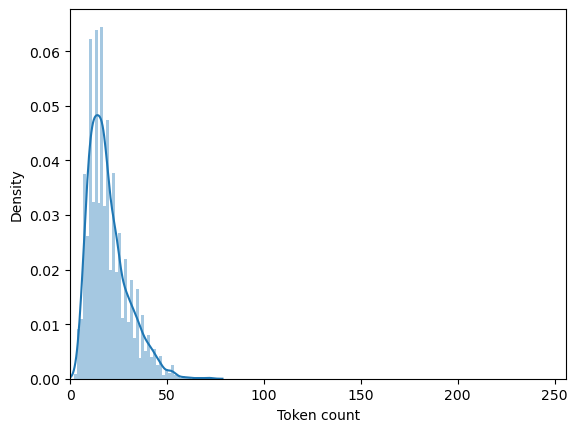

In [ ]:
token_lens = []

# Set max length to 512
for review in df.preprocess_text:
    tokens = tokenizer.encode(review, max_length=512)
    token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 256])
plt.xlabel('Token count')

In [ ]:
# Turns out we only need 80-ish tokens to work with
MAX_LEN = 80

# Preparing Torch Dataset
class ReviewDataset(Dataset):

    def __init__ (self, texts, targets, tokenizer, max_len):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        text = str(self.texts[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'news_text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
# dataloader

def create_data_loader(text, target, tokenizer, max_len, batch_size):
    ds = ReviewDataset(
        texts=text.to_numpy(),
        targets=target.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(X_train, y_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(X_test, y_test, tokenizer, MAX_LEN, BATCH_SIZE)

data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['news_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 80])
torch.Size([16, 80])
torch.Size([16])


c:\Users\fabian\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
bert_model = BertModel.from_pretrained(MODEL_NAME)

c:\Users\fabian\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\fabian\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [ ]:
# Sentiment Analysis class

class SentimentAnalysis(nn.Module):

    def __init__(self, n_classes):
        super(SentimentAnalysis, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3) # common dropout rate
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward_prop(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
# Instantiate Classifier
class_names = ['negative', 'neutral', 'positive']
model = SentimentAnalysis(len(class_names))
model = model.to(device)

# Hidden units
print(bert_model.config.hidden_size)

768


In [22]:
from transformers import AdamWeightDecay

NameError: name '_C' is not defined